In [1]:
import hoomd
from hoomd import *
from hoomd import md
from hoomd import deprecated
import math
import numpy
#hoomd.context.initialize();
#hoomd.context.initialize("--mode=gpu");
#hoomd.context.initialize("--mode=cpu");

In [2]:
def Simulate(eps,temp):
    hoomd.context.initialize("--mode=cpu")
    
    # parameters (polymer physics)
    phi_P = 0.25 # this has to do with how good of a solvent the polymer is in and is only used to calculate the box size below
    n_poly = 10 # n_poly is the number of polymers in the simulation
    n_beads = 30
        
    # This polymer can be made up of two different types A and B.  It's called a block copolymer.
    polymer1 = dict(bond_len=1.2, type=['B']*1 + ['A']*int(n_beads) + ['B']*1, bond="linear", count=n_poly)
    # perform some simple math to find the length of the box
    N = len(polymer1['type']) * polymer1['count']

    
    walls=md.wall.group(md.wall.sphere(r=5,origin=(0,0,0)))
    print(walls)

    # generate the polymer system
    system=deprecated.init.create_random_polymers(\
                                                  box=data.boxdim(volume=20*n_beads*math.pi * N / (6.0 * phi_P)), \
                                                  polymers=[polymer1],\
                                                  separation=dict(A=0.35, B=0.35)\
                                                  ,seed=12)
    
    # force field setup
    harmonic = md.bond.harmonic()
    harmonic.bond_coeff.set('polymer', k=330.0, r0=0.84)
    nl = md.nlist.cell();
    lj = md.pair.lj(r_cut=3.0,nlist=nl)
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0, alpha=0.0)
    lj.pair_coeff.set('A', 'B', epsilon=1.0, sigma=1.0, alpha=0.0)
    lj.pair_coeff.set('B', 'B', epsilon= eps, sigma=1.0, alpha=1.0)
    
    
    #add walls
    lj=md.wall.lj(walls, r_cut=3.0)
    lj.force_coeff.set('A', sigma=1.0,epsilon=1.0, alpha=0.0)
    lj.force_coeff.set('B', sigma=1.0,epsilon=1.0, alpha=0.0)
    
    # integrate NVT for a bunch of time steps
    all = group.all()
    md.integrate.mode_standard(dt=0.0005)
    md.integrate.nvt(group=all, kT= temp, tau=0.5)
    
    #save a gsd polymer configuration every 100 timesteps
    hoomd.dump.gsd("Distance_vs_Epsilon_Sim.gsd", period=1000, group=all, overwrite=True);
    
    #log position of particle 0
    polymers=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
    log = hoomd.analyze.log(filename="ree.log",
                            quantities=polymers[0:n_poly],
                            period=100,
                            overwrite=True);
    
    for i in range(n_poly):
        print(polymers[i],(n_beads+2)*i,(n_beads+2)*i+n_beads+1)
        log.register_callback(polymers[i], lambda timestep,i=i: math.sqrt( \
                                                                          (system.particles[(n_beads+2)*i].position[0]-system.particles[(n_beads+2)*i+n_beads+1].position[0])**2\
                                                                          +(system.particles[(n_beads+2)*i].position[1]-system.particles[(n_beads+2)*i+n_beads+1].position[1])**2\
                                                                          +(system.particles[(n_beads+2)*i].position[2]-system.particles[(n_beads+2)*i+n_beads+1].position[2])**2));
        
    run(1e6)

In [3]:
#Run simulation num_runs times incrementing epsilon. 
#Take Temperature as an input parameter      
num_runs = 3
d_eps = 50/(num_runs-1)
eps_min = 0
def L_vs_eps(temp):
    AvgL_vs_eps = numpy.array([])
    for i in range(num_runs):
        eps = eps_min + d_eps*i
        Simulate(eps,temp)
        ree_data = numpy.genfromtxt(fname='ree.log', skip_header=True)
        AvgL_vs_eps = numpy.append(AvgL_vs_eps,numpy.mean(ree_data[:,1:]))
    return AvgL_vs_eps #Average distance between ends versus epsilon data


AvgL_vs_eps = L_vs_eps(3)

print(AvgL_vs_eps)

HOOMD-blue v2.2.2-29-g1e86eec CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 01/29/18
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
Wall_Data_Sturucture:
spheres:1{
[0:	Radius=5	Origin=(0.0, 0.0, 0.0)	Inside=True]}
cylinders:0{}
planes:0{}
notice(2): Group "all" created containing 320 particles
('p1', 0, 31)
('p2', 32, 63)
('p3', 64, 95)
('p4', 96, 127)
('p5', 128, 159)
('p6', 160, 191)
('p7', 192, 223)
('p8', 224, 255)
('p9', 256, 287)
('p10', 288,

[ 0. 25. 50.]


<IPython.core.display.Javascript object>


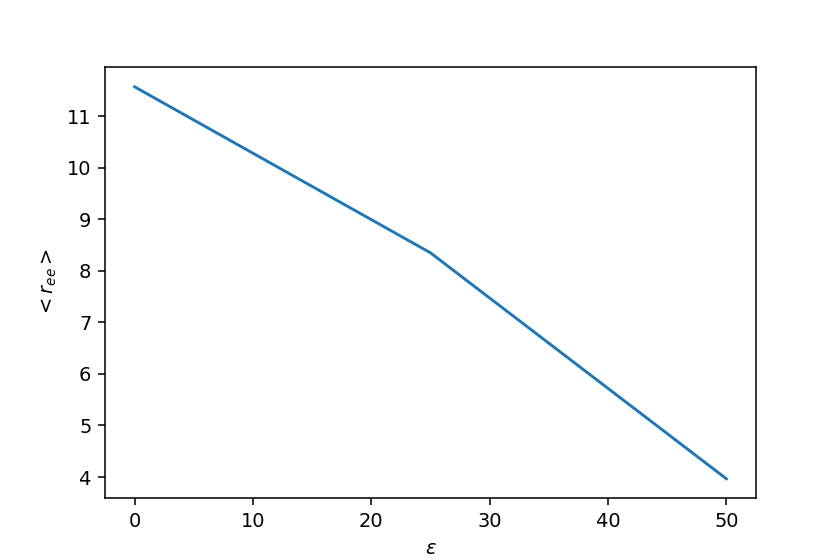

In [4]:
%matplotlib notebook
#%matplotlib inline
from matplotlib import pyplot as plt

x = numpy.array([])
for i in range(num_runs):
    x = numpy.append(x, eps_min + d_eps*i)
print(x)
y = AvgL_vs_eps
plt.figure(figsize=(6,4), dpi=140)
plt.plot(x, y)
plt.xlabel('$\epsilon$')
plt.ylabel('$<r_{ee}>$')
plt.show()
plt.savefig('Distance_vs_Epsilon_Sim.png')

In [5]:
!vmd -e vdw.vmd Distance_vs_Epsilon_Sim.gsd

/usr/local/lib/vmd/vmd_LINUXAMD64: /usr/lib/nvidia-390/libGL.so.1: no version information available (required by /usr/local/lib/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.4a12 (December 21, 2017)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 4 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 12GB (74%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1060 6GB 10 SM_6.1 1.84 GHz, 5.9GB RAM, KTO, AE2, ZCP
Warning) Detected X11 'Composite' extension: if incorrect display occurs